# 1 Introduction to diffusion models

license: Apache-2.0 license

referece: 
- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=DPTzwfAgYWGi
- https://github.com/huggingface/diffusion-models-class/tree/main?tab=Apache-2.0-1-ov-file

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt

## 1.1 MNIST dataset

In [3]:
dataset = torchvision.datasets.MNIST(root="data/mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Input shape: torch.Size([16, 1, 28, 28])
Labels: tensor([2, 7, 5, 6, 0, 9, 8, 9, 4, 1, 1, 7, 2, 2, 0, 4])


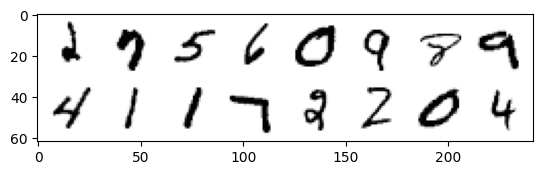

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 1.2 build our own duffision models

In [49]:
from diffusers import UNet2DModel

class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
                h.append(x) # Storing output for skip connection
                x = self.downscale(x) # Downscale ready for the next layer
        
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
                x = self.upscale(x) # Upscale
                x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
        
        return x

class UNetWrapper(nn.Module):
    """A wrapper for the UNet model.

    Picking whther to use the basic or the diffuser model.
    """
    def __init__(self, model_name="unet_mini"):
        super().__init__()
        self.model_name = model_name
        if model_name == "unet_mini":
            self.model = BasicUNet()
        elif model_name == "unet_attn":
            self.model = UNet2DModel(
                sample_size=28,  # the target image resolution
                in_channels=1,  # the number of input channels, 3 for RGB images
                out_channels=1,  # the number of output channels
                layers_per_block=2,  # how many ResNet layers to use per UNet block
                block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
                down_block_types=( 
                    "DownBlock2D",  # a regular ResNet downsampling block
                    "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                    "AttnDownBlock2D",
                ), 
                up_block_types=(
                    "AttnUpBlock2D", 
                    "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                    "UpBlock2D",   # a regular ResNet upsampling block
                ),
            )
        else:
            raise ValueError("Unknown model name")
    
    def forward(self, x):
        if self.model_name == "unet_mini":
            return self.model(x)
        elif self.model_name == "unet_attn":
            # use 0 for a kind of bypassing timestep embedding
            return self.model(x, 0).sample

    def count_params(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

In [6]:
model = UNetWrapper("unet_attn")
model.count_params()

1707009

# 1.3 Define diffusion process function
Here we define a simple noising function

In [7]:
def corrupt(x, amount, rand_fn="rand"):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  if rand_fn == "rand":
    noise = torch.rand_like(x)
  elif rand_fn == "randn":
    noise = torch.randn_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

Amount of corruption: tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333, 1.0000])


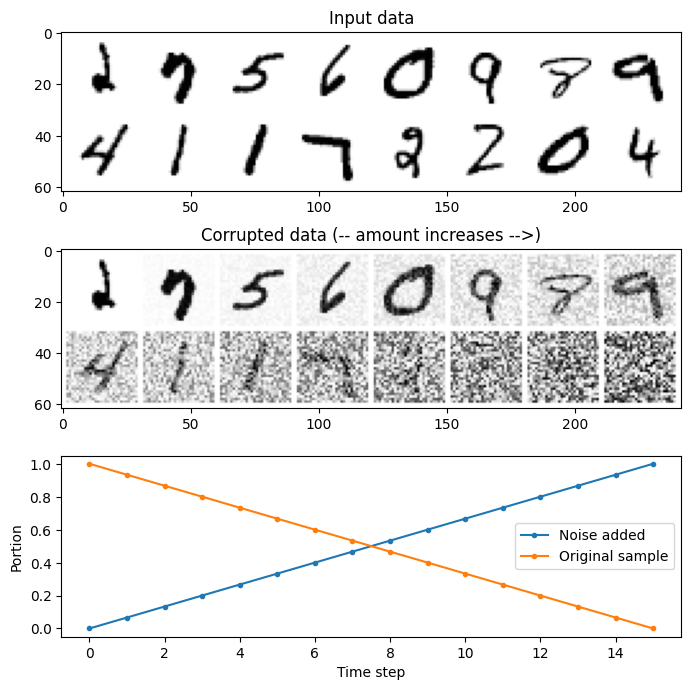

In [8]:
# Plotting the input data
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
print('Amount of corruption:', amount)
noised_x = corrupt(x, amount, "rand")

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

# Plotting proportion of noise to an input sample
sample_portion = 1-amount
axs[2].plot(amount, '.-')
axs[2].plot(sample_portion, '.-')
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Portion')
axs[2].legend(['Noise added', 'Original sample']);

## 1.4 Training the diffusion model

Finished epoch 0. Average loss for this epoch: 0.027559
Finished epoch 1. Average loss for this epoch: 0.021496
Finished epoch 2. Average loss for this epoch: 0.019647
Finished epoch 3. Average loss for this epoch: 0.018439
Finished epoch 4. Average loss for this epoch: 0.018262
Finished epoch 5. Average loss for this epoch: 0.017260
Finished epoch 6. Average loss for this epoch: 0.017034
Finished epoch 7. Average loss for this epoch: 0.016818
Finished epoch 8. Average loss for this epoch: 0.016624
Finished epoch 9. Average loss for this epoch: 0.016635


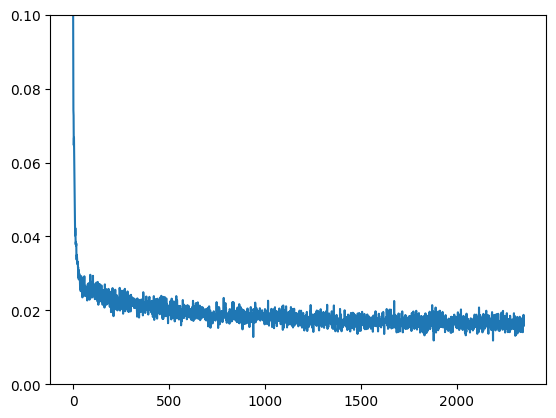

In [9]:
# Dataloader (you can mess with batch size)
batch_size = 256
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
model_name = "unet_mini" # unet_mini or "unet_attn"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = UNetWrapper(model_name)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts from a unit uniform distribution
        noisy_x = corrupt(x, noise_amount, rand_fn="rand") # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

## 1.5 Sampling from the random inputs

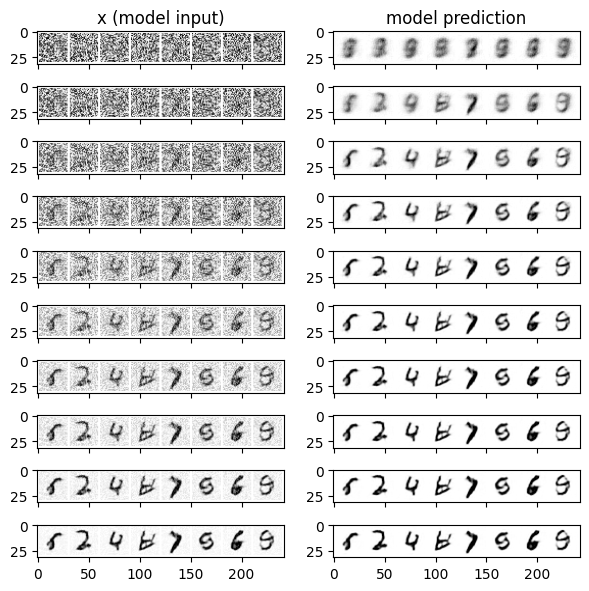

In [10]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 10 # < - change number of steps here to get higher quality results (hopefully)
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(7, 7), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

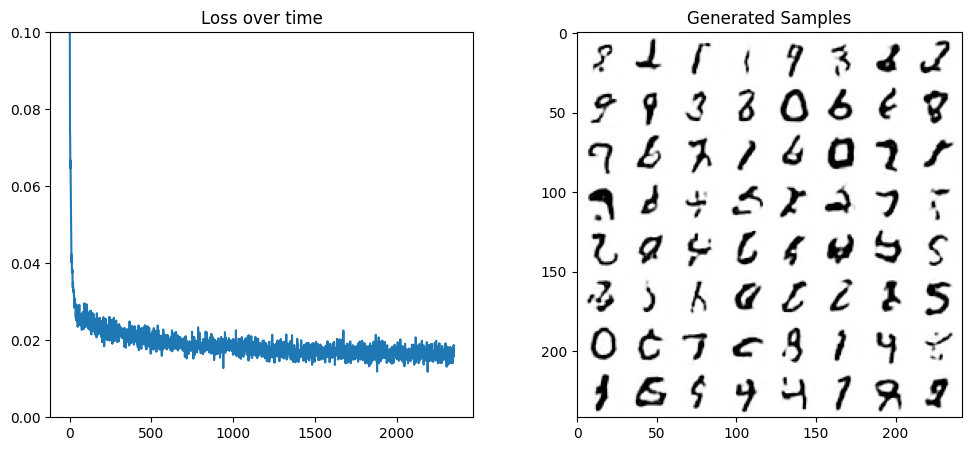

In [11]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')
# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

# 2 Class-conditioned Diffusion model

- reference: https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb#scrollTo=k_d6S0Fwlahy

## 2.1 Define class-conditioned diffusion model

In [13]:
class CCUNet(nn.Module):
    """ Class-conditioned Diffusion model """

    def __init__(self, model_name="unet_attn", class_emb_size=4):
        super().__init__()
        self.model_name = model_name
        self.class_emb_size = class_emb_size
        self.class_emb = nn.Embedding(10, 4)

        if model_name == "unet_mini":
            self.model = BasicUNet(1 + class_emb_size, 1)
        elif model_name == "unet_attn":
            self.model = UNet2DModel(
                sample_size=28,           # the target image resolution
                in_channels=1 + class_emb_size, # Additional input channels for class cond.
                out_channels=1,           # the number of output channels
                layers_per_block=2,       # how many ResNet layers to use per UNet block
                block_out_channels=(32, 64, 64), 
                down_block_types=( 
                    "DownBlock2D",        # a regular ResNet downsampling block
                    "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                    "AttnDownBlock2D",
                ), 
                up_block_types=(
                    "AttnUpBlock2D", 
                    "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                    "UpBlock2D",          # a regular ResNet upsampling block
                ),
            )

    def forward(self, x, class_labels):
        BS, C, W, H = x.shape

        class_cond = self.class_emb(class_labels) # Map to embedding dimension
        class_cond = class_cond.view(BS, class_cond.shape[1], 1, 1).expand(BS, class_cond.shape[1], W, H)
        x = torch.cat((x, class_cond), dim=1) # (BS, C+4, W, H)

        if self.model_name == "unet_mini":
            return self.model(x)
        elif self.model_name == "unet_attn":
            return self.model(x, 0).sample

## 2.2 Training the class-conditioned model

Finished epoch 0. Average loss for this epoch: 0.031460
Finished epoch 1. Average loss for this epoch: 0.021099
Finished epoch 2. Average loss for this epoch: 0.018960
Finished epoch 3. Average loss for this epoch: 0.017645
Finished epoch 4. Average loss for this epoch: 0.016581
Finished epoch 5. Average loss for this epoch: 0.016057
Finished epoch 6. Average loss for this epoch: 0.015525
Finished epoch 7. Average loss for this epoch: 0.015152
Finished epoch 8. Average loss for this epoch: 0.014831
Finished epoch 9. Average loss for this epoch: 0.014732


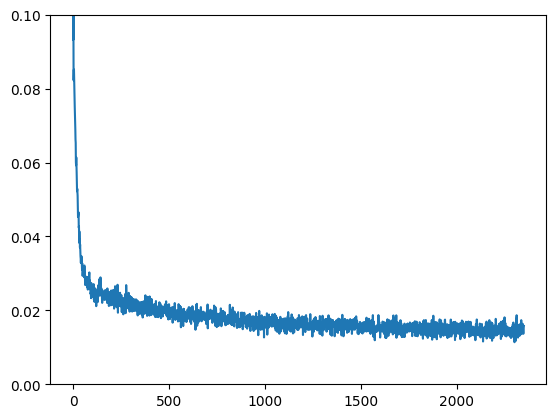

In [14]:
# Dataloader (you can mess with batch size)
batch_size = 256
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
model_name = "unet_mini" # unet_mini or "unet_attn"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = CCUNet(model_name)
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        y = y.to(device) # Labels on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount, rand_fn="rand") # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, y)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

## 2.3 Sampling by conditioning the model with classes

100%|██████████| 90/90 [00:00<00:00, 1597.25it/s]


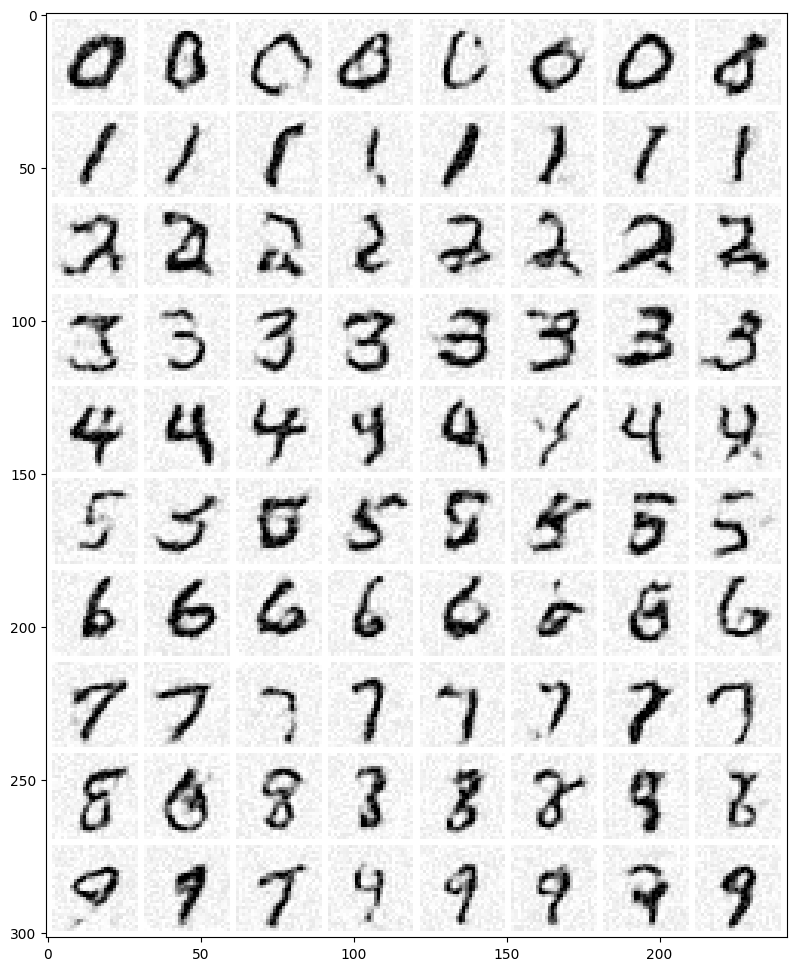

In [47]:
from tqdm import tqdm

# Prepare random x to start from, plus some desired labels y
x = torch.rand(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

n_steps = 90 # try 50

# Sampling loop
for t in tqdm(range(n_steps)):

    # Get model pred
    with torch.no_grad():
        pred = net(x, y)  # Again, note that we pass in our labels y

    # Update sample with step
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor      

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0].clip(0, 1), cmap='Greys')